In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/faz-preprocessing/FAZ_preprocessing/clear/Diabetic_clear (100).jpg
/kaggle/input/faz-preprocessing/FAZ_preprocessing/clear/Myopia_clear (78).jpg
/kaggle/input/faz-preprocessing/FAZ_preprocessing/clear/Normal_clear (64).jpg
/kaggle/input/faz-preprocessing/FAZ_preprocessing/clear/Myopia_clear (59).jpg
/kaggle/input/faz-preprocessing/FAZ_preprocessing/clear/Normal_clear (80).jpg
/kaggle/input/faz-preprocessing/FAZ_preprocessing/clear/Normal_clear (33).jpg
/kaggle/input/faz-preprocessing/FAZ_preprocessing/clear/Myopia_clear (48).jpg
/kaggle/input/faz-preprocessing/FAZ_preprocessing/clear/Normal_clear (16).jpg
/kaggle/input/faz-preprocessing/FAZ_preprocessing/clear/Myopia_clear (53).jpg
/kaggle/input/faz-preprocessing/FAZ_preprocessing/clear/Myopia_clear (82).jpg
/kaggle/input/faz-preprocessing/FAZ_preprocessing/clear/Diabetic_clear (2).jpg
/kaggle/input/faz-preprocessing/FAZ_preprocessing/clear/Myopia_clear (83).jpg
/kaggle/input/faz-preprocessing/FAZ_preprocessing/clear/Myop

In [2]:
import os
import cv2 
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
INPUT_IMAGE_PATH='/kaggle/input/faz-preprocessing/FAZ_preprocessing/clear'
INPUT_MASK_PATH='/kaggle/input/faz-preprocessing/FAZ_preprocessing/masks'
OUTPUT_IMAGE_PATH='/kaggle/working/preprocessed_images'
OUTPUT_MASK_PATH='/kaggle/working/preprocessed_masks'

In [4]:
os.makedirs(OUTPUT_IMAGE_PATH, exist_ok=True)
os.makedirs(OUTPUT_MASK_PATH, exist_ok=True)


In [5]:
clahe=cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))


In [6]:
def crop_center(img, cropx=400, cropy=400):
    y,x =img.shape[:2]
    startx=x//2-cropx//2
    starty=y//2-cropy//2
    return img[starty:starty+cropy, startx:startx+cropx]

In [7]:
def preprocess_image(image_path):
    img=cv2.imread(image_path)
    if img is None:
        print(f"Image not loaded:{image_path}")
        return None

    
    #resize
    img=cv2.resize(img,(512,512))
    
    #crop around center(fovea)
    img=crop_center(img, 400,400)
    
    #CLAHE
    gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    clahe_img=clahe.apply(gray)

    #convert back to 3 channels
    img_clahe=cv2.cvtColor(clahe_img, cv2.COLOR_GRAY2BGR)
    #denoise
    img_denoised=cv2.GaussianBlur(img_clahe,(3,3),0)

    #Normalize (0 to 1)
    img_norm=img_denoised.astype(np.float32)/255.0
    return img_norm

In [8]:
def preprocess_mask(mask_path):
    mask=cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        print(f" Could not read mask: {mask_path}")
        return None
    mask=cv2.resize(mask, (512,512))
    
    mask=crop_center(mask, 400,400)
    
    _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    
    return mask

In [9]:
image_files=sorted(os.listdir(INPUT_IMAGE_PATH))
mask_files=sorted(os.listdir(INPUT_MASK_PATH))


In [10]:
from tqdm import tqdm

for image_file, mask_file in tqdm(zip(image_files, mask_files), total=len(image_files)):
    
    image_path = os.path.join(INPUT_IMAGE_PATH, image_file)
    mask_path = os.path.join(INPUT_MASK_PATH, mask_file)
    
    img_processed = preprocess_image(image_path)
    mask_processed = preprocess_mask(mask_path)
    
    if img_processed is None or mask_processed is None:
        print(f" Skipping: {image_file}, {mask_file}")
        continue
    
    
    img_save = (img_processed * 255).astype(np.uint8)
    save_img_path = os.path.join(OUTPUT_IMAGE_PATH, image_file)
    cv2.imwrite(save_img_path, img_save)

    
    save_mask_path = os.path.join(OUTPUT_MASK_PATH, mask_file)
    cv2.imwrite(save_mask_path, mask_processed)

print("\n Preprocessing complete! Saved to:")
print(f"Images: {OUTPUT_IMAGE_PATH}")
print(f"Masks:  {OUTPUT_MASK_PATH}")



100%|██████████| 304/304 [00:07<00:00, 43.06it/s]


 Preprocessing complete! Saved to:
Images: /kaggle/working/preprocessed_images
Masks:  /kaggle/working/preprocessed_masks


In [11]:
import shutil
shutil.make_archive('/kaggle/working/pre-processed_images', 'zip', '/kaggle/working/preprocessed_images')
shutil.make_archive('/kaggle/working/pre-processed_masks', 'zip', '/kaggle/working/preprocessed_masks')


'/kaggle/working/pre-processed_masks.zip'

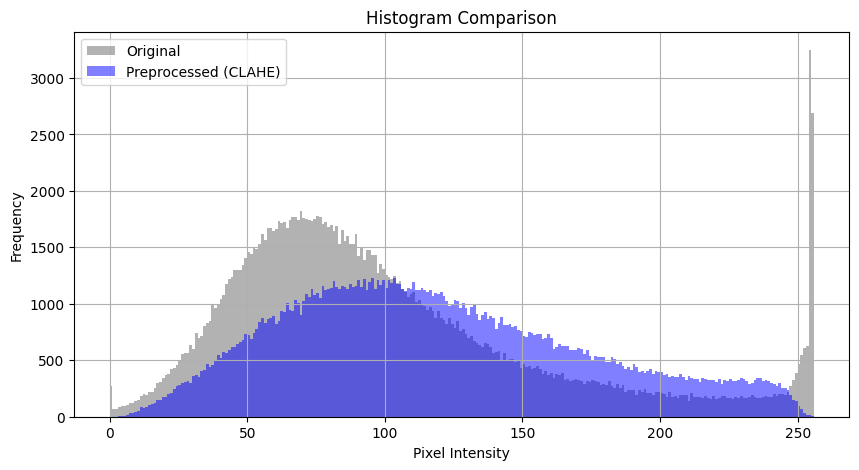

In [13]:
import cv2
import matplotlib.pyplot as plt

# Load images
raw_img = cv2.imread('/kaggle/input/faz-preprocessing/FAZ_preprocessing/clear/Diabetic_clear (1).jpg', cv2.IMREAD_GRAYSCALE)
processed_img = cv2.imread('/kaggle/working/preprocessed_images/Diabetic_clear (1).jpg', cv2.IMREAD_GRAYSCALE)

# Plot histograms
plt.figure(figsize=(10,5))
plt.hist(raw_img.ravel(), 256, [0,256], label='Original', color='gray', alpha=0.6)
plt.hist(processed_img.ravel(), 256, [0,256], label='Preprocessed (CLAHE)', color='blue', alpha=0.5)
plt.title("Histogram Comparison")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()


In [15]:
import cv2
import numpy as np

# Load grayscale versions
raw_img = cv2.imread('/kaggle/input/faz-preprocessing/FAZ_preprocessing/clear/Diabetic_clear (14).jpg', cv2.IMREAD_GRAYSCALE)
processed_img = cv2.imread('/kaggle/working/preprocessed_images/Diabetic_clear (14).jpg', cv2.IMREAD_GRAYSCALE)

# Function to compute sharpness (variance of Laplacian)
def compute_sharpness(img):
    return cv2.Laplacian(img, cv2.CV_64F).var()

# Compute sharpness
raw_sharpness = compute_sharpness(raw_img)
processed_sharpness = compute_sharpness(processed_img)

print(f"🔹 Sharpness (Original): {raw_sharpness:.2f}")
print(f"🔹 Sharpness (Preprocessed - CLAHE): {processed_sharpness:.2f}")


🔹 Sharpness (Original): 9109.25
🔹 Sharpness (Preprocessed - CLAHE): 1613.37


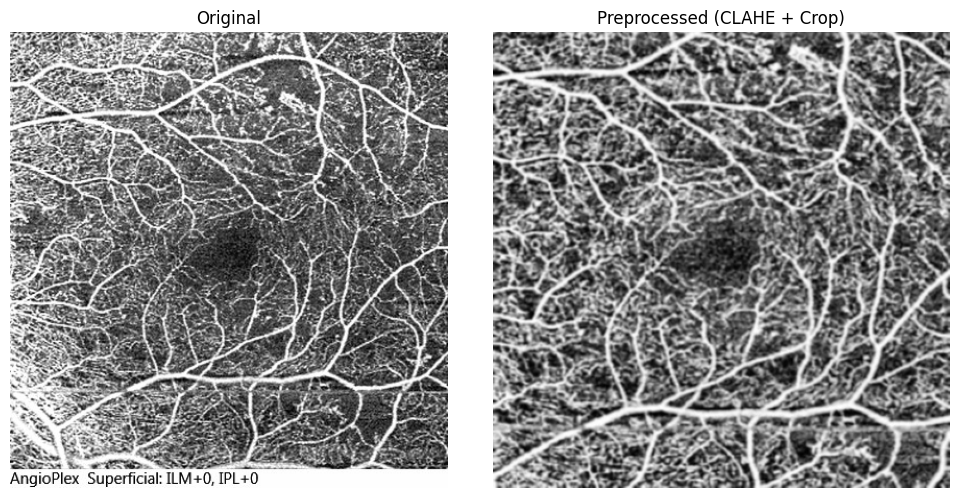

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(cv2.imread('/kaggle/input/faz-preprocessing/FAZ_preprocessing/clear/Diabetic_clear (103).jpg'), cmap='gray')
axes[0].set_title('Original')
axes[0].axis('off')

axes[1].imshow(cv2.imread('/kaggle/working/preprocessed_images/Diabetic_clear (103).jpg'), cmap='gray')
axes[1].set_title('Preprocessed (CLAHE + Crop)')
axes[1].axis('off')

plt.tight_layout()
plt.show()
